In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve

### Load data

In [37]:
users = pd.read_csv(r'C:\Users\Evan\Desktop\relax_challenge\takehome_users.csv', encoding = 'latin-1', parse_dates=['creation_time'])
engagement = pd.read_csv(r'C:\Users\Evan\Desktop\relax_challenge\takehome_user_engagement.csv', parse_dates=['time_stamp'])

### Inspect data

In [38]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [39]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [40]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [41]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [42]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Identify which users are adopters and which are multi adopters and merge that info back into the users dataframe

In [43]:
engagement['time_stamp'] = engagement['time_stamp'].dt.floor('d').astype(np.int64)
#sorting and remove duplicated days per users 
engagement = engagement.sort_values(['user_id', 'time_stamp']).drop_duplicates()

a = engagement.groupby('user_id')['time_stamp'].rolling(window=3)
b = pd.to_timedelta((a.max()- a.min())).dt.days


adopters = b[b <= 7].index.get_level_values('user_id').unique()

In [44]:
len(adopters)

1656

In [45]:
# Make column for 'adopter' in the users df
users['adopter'] = 0
users.loc[(users['object_id'].isin(list(adopters))), 'adopter'] = 1

### Feature Engineering

In [46]:
# Get list of users who have invited others and make 'has_invited_other' column in users df
users['counter'] = 1
users_who_invited = list(users.groupby(by='invited_by_user_id').count()['counter'].index)
users.drop('counter', axis=1)

users['has_invited_other'] = 0
users.loc[(users['object_id'].isin(users_who_invited)), 'has_invited_other'] = 1


# Make column 'num_invited' for the number of users a user has invited
num_invited = users.groupby(by='invited_by_user_id').count()['counter']
users['num_invited'] = 0
for idx, user in enumerate(users['object_id']):
    if user in users_who_invited:
        users.loc[idx, 'num_invited'] = num_invited[user]

In [47]:
# Make column 'org_size' with the number of users in the user's organization
org_sizes = users.groupby(by='org_id').count()['counter']
users['org_size'] = 0
for idx, org in enumerate(users['org_id']):
    if org in org_sizes.index:
        users.loc[idx, 'org_size'] = org_sizes[org]

In [48]:
# Make column 'invited_by_adopter' to signify whether a user was invited by a multi_adopter
users['invited_by_adopter'] = 0
for idx, inviter in enumerate(users['invited_by_user_id']):
    if inviter in adopters:
        users.loc[idx, 'invited_by_adopter'] = 1

In [49]:
# Make column 'email_provider' to indicate which email provider the user used to sign up


def get_email(string):
    email = string.split('@')[1].split('.')[0]
    return email

users['email_provider'] = users['email'].apply(get_email)

common_providers = users.email_provider.value_counts()[0:6].index.to_list()

users['email_provider'] = [email if email in common_providers else 'other' for email in users['email_provider']]


In [50]:
users.email_provider.value_counts()

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email_provider, dtype: int64

In [51]:
users['email_provider'].value_counts()

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email_provider, dtype: int64

### EDA

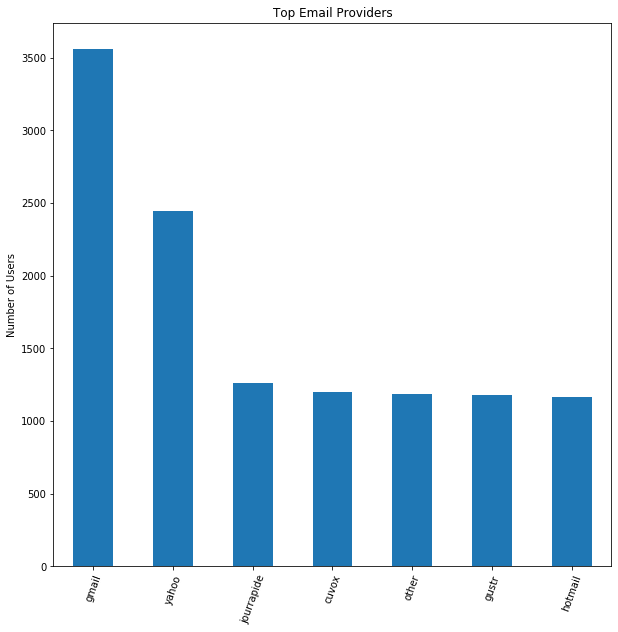

In [52]:
users.email_provider.value_counts().plot(kind='bar')
plt.title('Top Email Providers')
plt.ylabel('Number of Users')
plt.xticks(rotation=70)
plt.show()

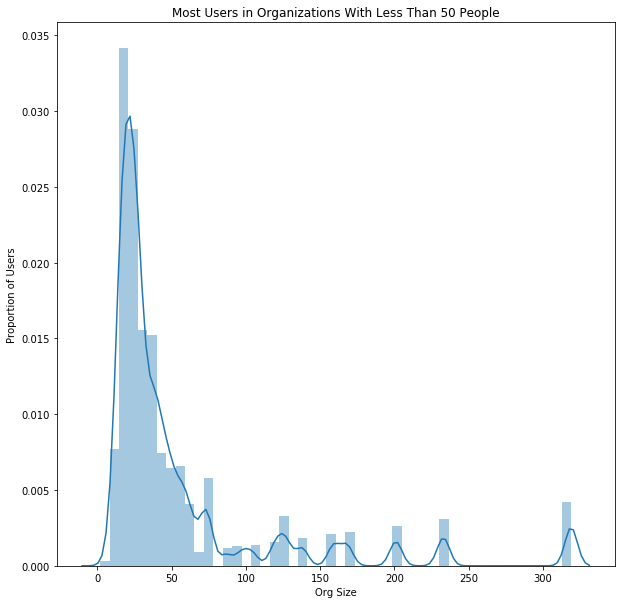

In [81]:
sns.distplot(users['org_size'])
plt.title('Most Users in Organizations With Less Than 50 People')
plt.ylabel('Proportion of Users')
plt.xlabel('Org Size')
plt.savefig(r'C:\Users\Evan\Desktop\relax_challenge\images\org_sizes.png')
plt.show()

### Adopters make up a small percentage of all users
* These are imbalanced classes

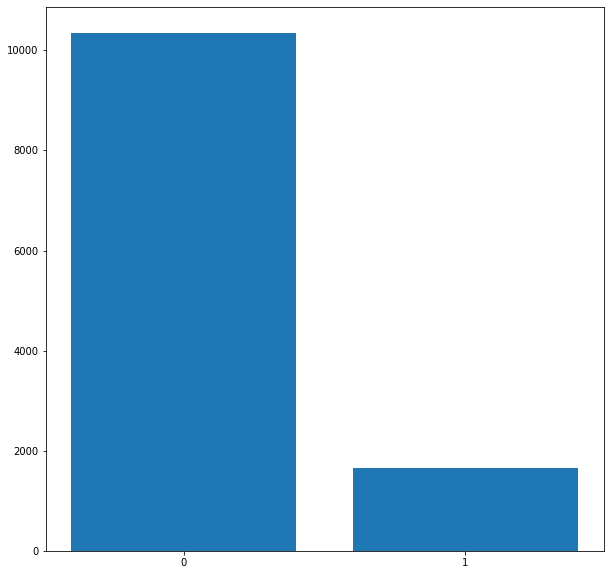

Non-adopters: 10344
Adopter: 1656


In [54]:
data = users['adopter'].value_counts()

plt.bar(data.index, data.values)
plt.xticks([0, 1])
plt.show()

print('Non-adopters: {}'.format(data.values[0]))
print('Adopter: {}'.format(data.values[1]))


### Most adopters are not opted in to mailing list

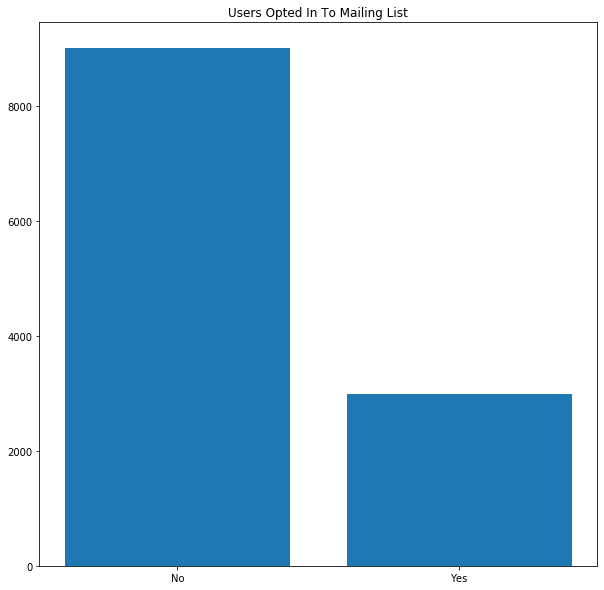

In [55]:
data = users['opted_in_to_mailing_list'].value_counts()
data.index = ['No', 'Yes']
plt.bar(data.index, data.values)
plt.title('Users Opted In To Mailing List')
plt.show()

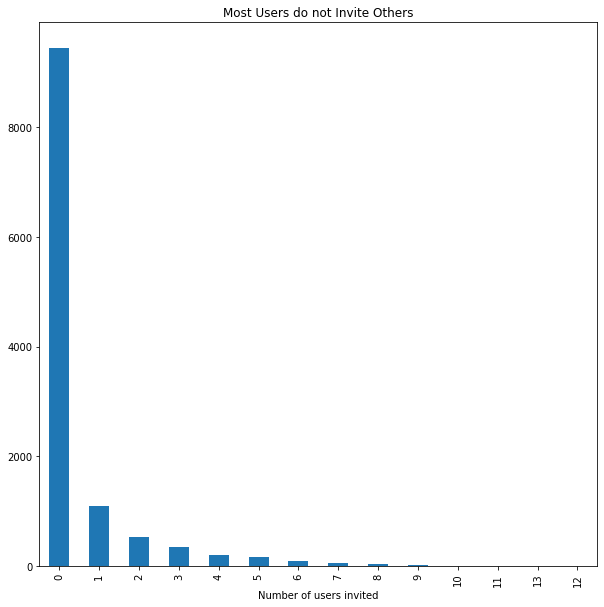

In [82]:
users['num_invited'].value_counts().plot(kind='bar')
plt.title('Most Users do not Invite Others')
plt.xlabel('Number of users invited')
plt.savefig(r'C:\Users\Evan\Desktop\relax_challenge\images\invites.png')
plt.show()

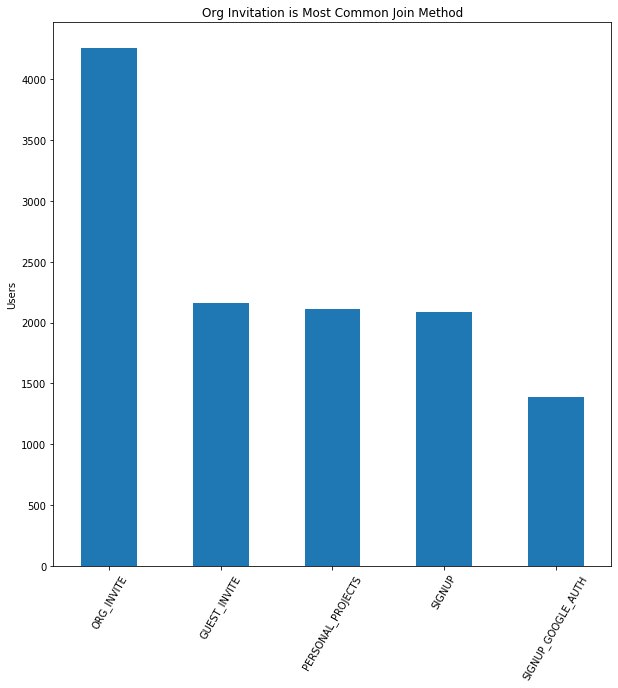

In [57]:
users['creation_source'].value_counts().plot(kind='bar')
plt.xticks(rotation=60)
plt.title('Org Invitation is Most Common Join Method')
plt.ylabel('Users')
plt.show()

### Build Models

In [58]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopter                     12000 non-null  int64         
 11  counter                     12000 non-null  int64     

### Make Dummies

In [59]:
users = pd.concat([users, pd.get_dummies(users['creation_source']), pd.get_dummies(users['email_provider'])], axis=1)

### Drop unneccesary columns

In [60]:
users_numeric = users.drop(labels = ['object_id', 'creation_time', 'name', 'email', 'creation_source', 'last_session_creation_time',
                                     'invited_by_user_id', 'counter', 'email_provider', 'org_id'], axis=1)

### Scale and split the data into train/test

In [61]:
X = users_numeric.drop(labels=['adopter'], axis=1)
y = users['adopter']

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [62]:
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,has_invited_other,num_invited,org_size,invited_by_adopter,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,cuvox,gmail,gustr,hotmail,jourrapide,other,yahoo
0,1,0,0,0,75,0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,233,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0,0,1,1,32,1,0,1,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,233,1,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,16,1,1,0,0,0,0,0,0,0,0,0,0,1


### Build Models

In [63]:
model = TSNE(learning_rate = 500, random_state=42)
transformed = model.fit_transform(X)

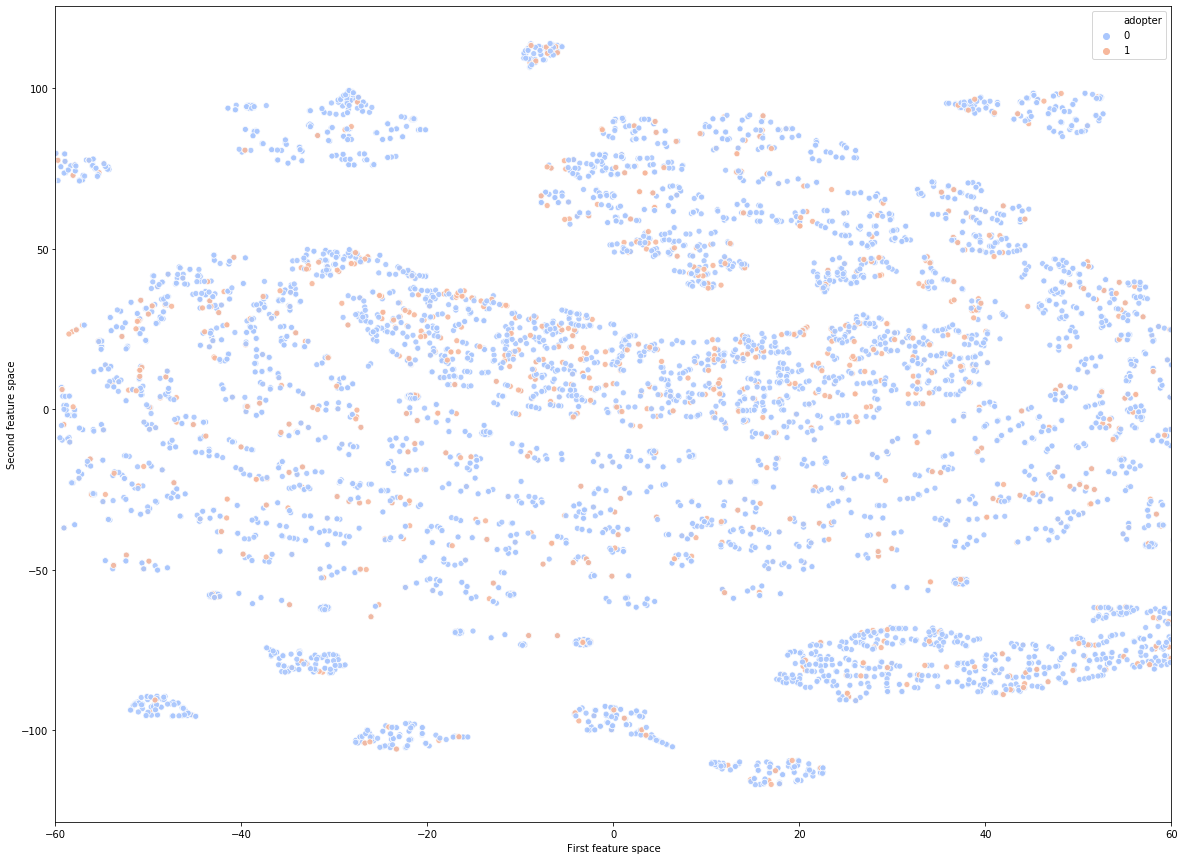

In [83]:
plt.rcParams["figure.figsize"] = (20,15)
xs = transformed[:,0]
ys = transformed[:,1]

sns.scatterplot(xs, ys, hue=y, palette='coolwarm', alpha=0.9)
plt.xlim(-60,60)
plt.xlabel('First feature space')
plt.ylabel('Second feature space')
plt.savefig(r'C:\Users\Evan\Desktop\relax_challenge\images\dimensionality_reduction')
plt.show()

### Gradient Boosting Classifier

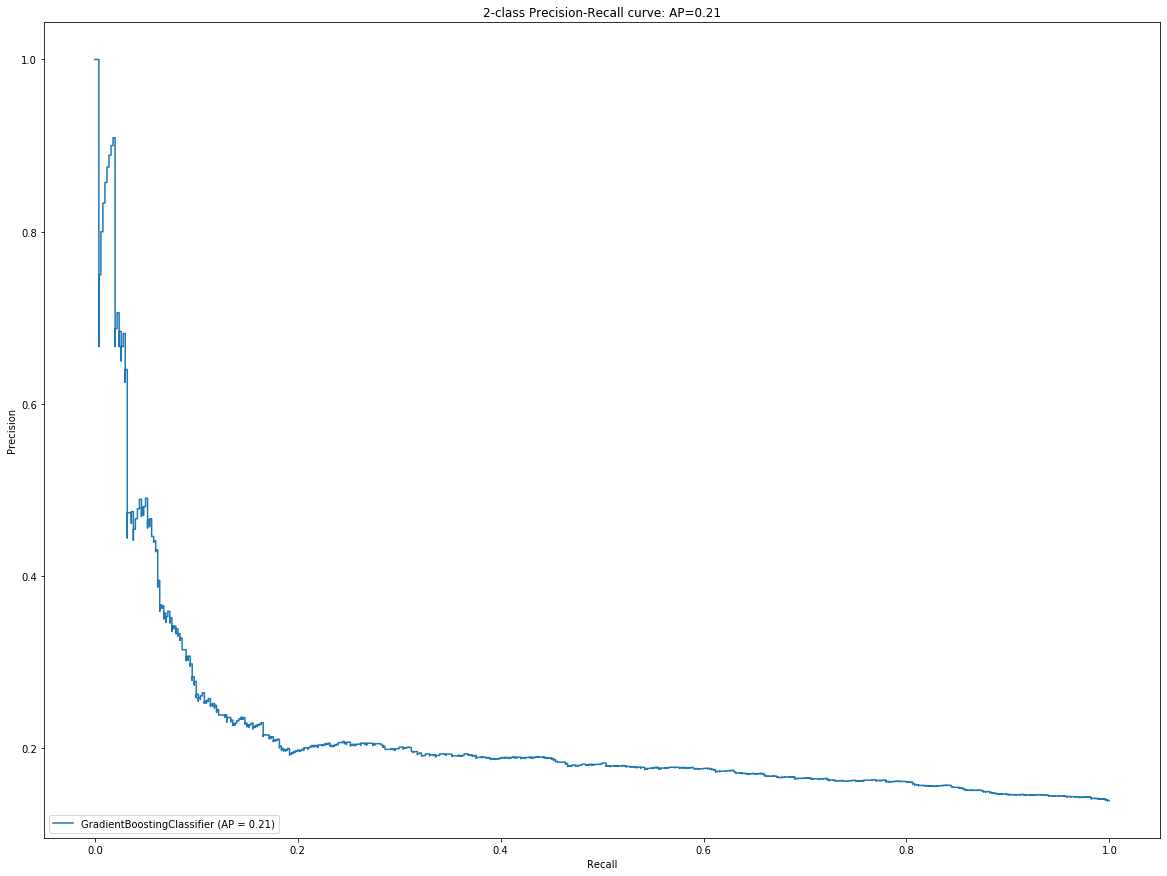

{'subsample': 0.8, 'n_estimators': 90, 'min_samples_split': 10, 'loss': 'exponential', 'learning_rate': 0.1}
Gradient Boosting Precision-Recall Score: 0.21


In [65]:
param_grid = {
    'loss': ['exponential'],
    'learning_rate': [0.05, 0.1, 0.2, 1],
    'n_estimators': [60, 70, 80, 90, 100],
    'min_samples_split': [10],
    'subsample': [0.8]
}

gb = GradientBoostingClassifier()
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
gbc = RandomizedSearchCV(gb, param_distributions=param_grid, cv=cv, random_state=42, n_jobs=-1)

gbc.fit(X_train, y_train)

y_score = gbc.decision_function(X_test)

average_precision = average_precision_score(y_test, y_score)

pr_disp = plot_precision_recall_curve(gbc.best_estimator_, X_test, y_test)
pr_disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.show()

print(gbc.best_params_)
print('Gradient Boosting Precision-Recall Score: {0:0.2f}'.format(average_precision))

### Support Vector Classifier

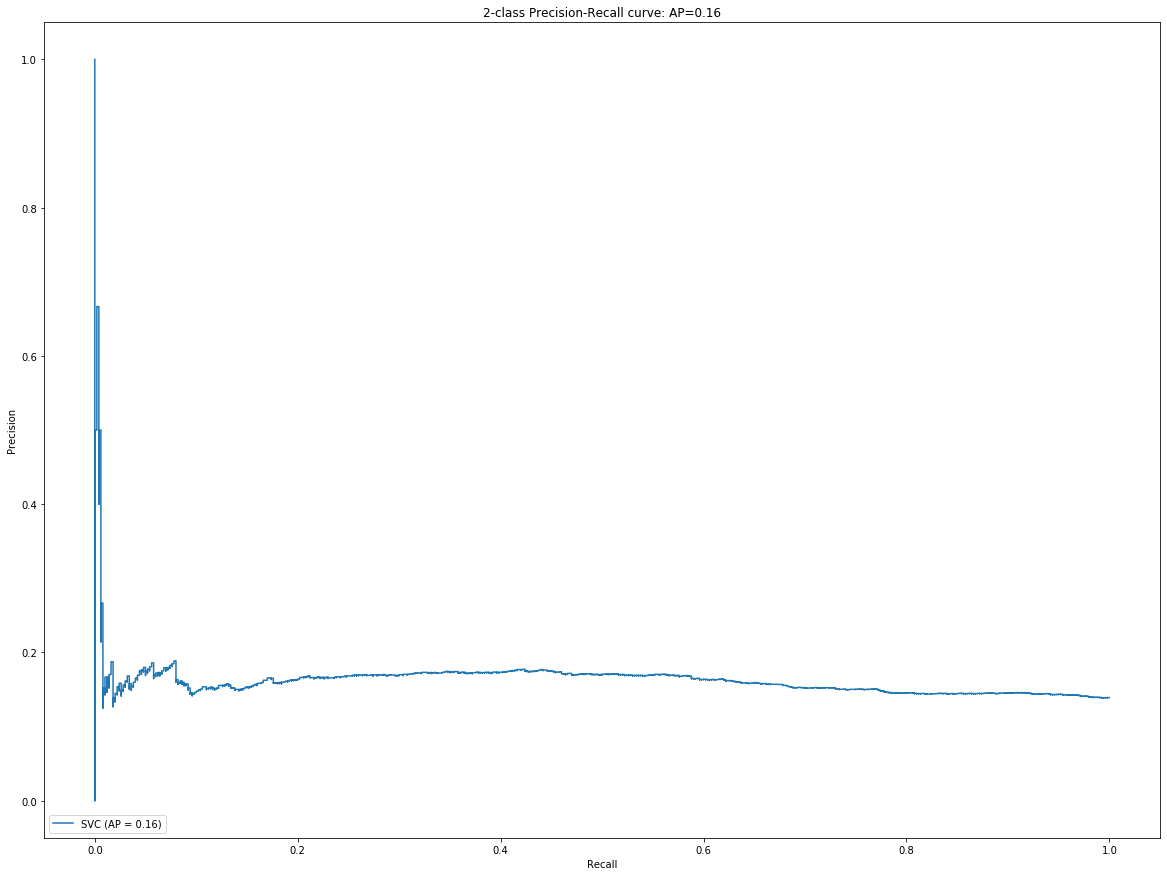

{'kernel': 'rbf', 'gamma': 'scale', 'C': 1000}
rbf_svc Average Precision: 0.1627209122996129


In [66]:
svc = svm.SVC(class_weight='balanced', probability=True)

param_grid = [
      {'C': [0.5, 1, 10, 100, 1000], 
       'gamma': ['scale', 'auto', 0.001, 0.0001], 
       'kernel': ['rbf', 'poly', 'sigmoid'],
       }
 ]
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
rbf_svc = RandomizedSearchCV(svc, param_distributions=param_grid, cv=cv, random_state=42, n_jobs=-1)

rbf_svc.fit(X_train, y_train)

y_score = rbf_svc.decision_function(X_test)

average_precision = average_precision_score(y_test, y_score)

pr_disp = plot_precision_recall_curve(rbf_svc.best_estimator_, X_test, y_test)
pr_disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.show()

print(rbf_svc.best_params_)
print('rbf_svc Average Precision: {}'.format(average_precision))

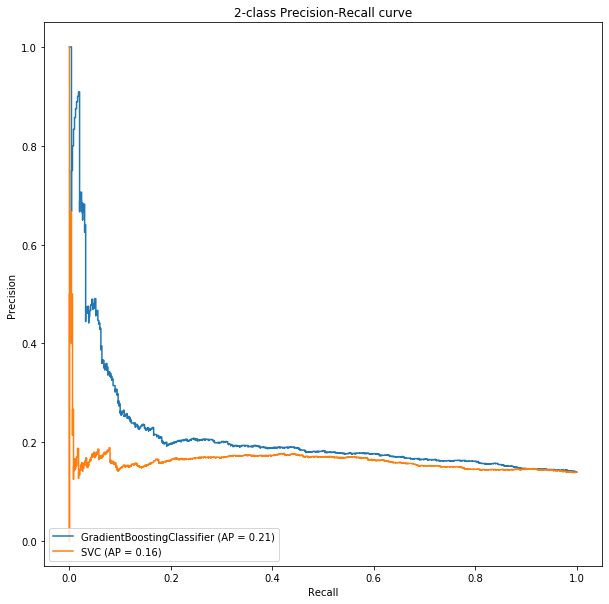

In [80]:
fig, ax = plt.subplots()

pr_disp = plot_precision_recall_curve(gbc.best_estimator_, X_test, y_test, ax=ax)
pr_disp.ax_.set_title('2-class Precision-Recall curve')
pr_disp = plot_precision_recall_curve(rbf_svc.best_estimator_, X_test, y_test, ax=ax)
plt.savefig(r'C:\Users\Evan\Desktop\relax_challenge\images\model_comparison.png')
plt.show()

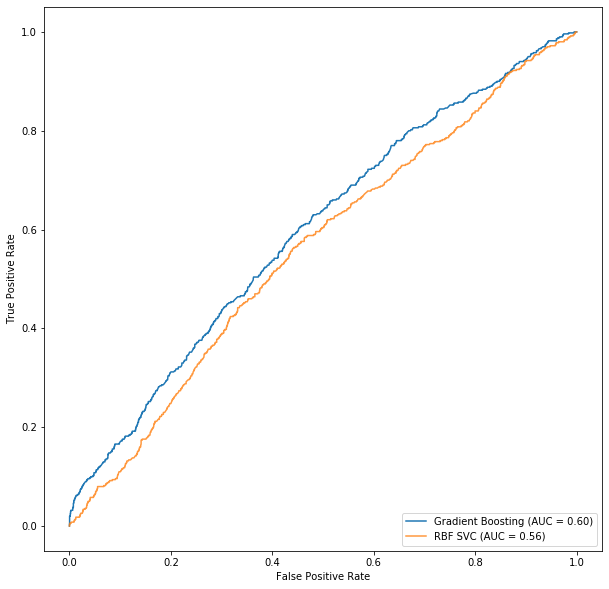

In [67]:
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()

gbc_disp = plot_roc_curve(gbc, X_test, y_test, ax=ax, name='Gradient Boosting')
rbf_svc_disp = plot_roc_curve(rbf_svc, X_test, y_test, ax=ax, alpha=0.8, name='RBF SVC')

plt.show()

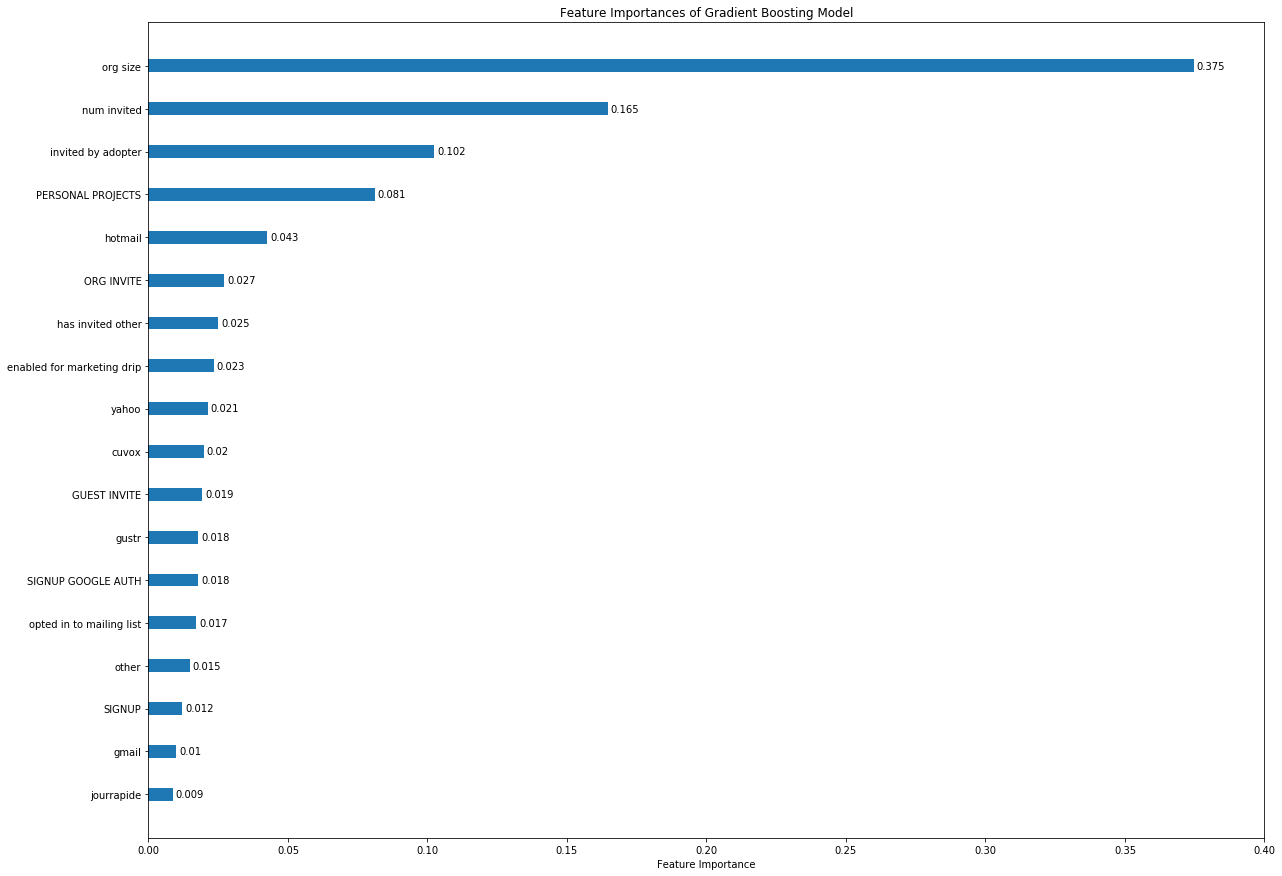

In [84]:
features = [sub.replace('_', ' ') for sub in X.columns]
importances = pd.DataFrame(list(zip(features, gbc.best_estimator_.feature_importances_)),
                              columns=['feature', 'importance'])
importances.sort_values(by='importance', ascending=True, inplace=True)

ax = plt.barh(importances.feature, importances.importance, height=0.3, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importances of Gradient Boosting Model')

for i in ax.patches:
    plt.text(i.get_width()+.001, i.get_y()+0.08, 
           str(round(i.get_width(),3)))
plt.xlim([0,.4])
plt.savefig(r'C:\Users\Evan\Desktop\relax_challenge\images\feature_importances.png')
plt.show()

In [69]:
X.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'has_invited_other', 'num_invited', 'org_size', 'invited_by_adopter',
       'GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP',
       'SIGNUP_GOOGLE_AUTH', 'cuvox', 'gmail', 'gustr', 'hotmail',
       'jourrapide', 'other', 'yahoo'],
      dtype='object')

In [70]:
users_numeric.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopter,has_invited_other,num_invited,org_size,invited_by_adopter,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,cuvox,gmail,gustr,hotmail,jourrapide,other,yahoo
0,1,0,0,0,0,75,0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,233,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,1,32,1,0,1,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,233,1,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,16,1,1,0,0,0,0,0,0,0,0,0,0,1


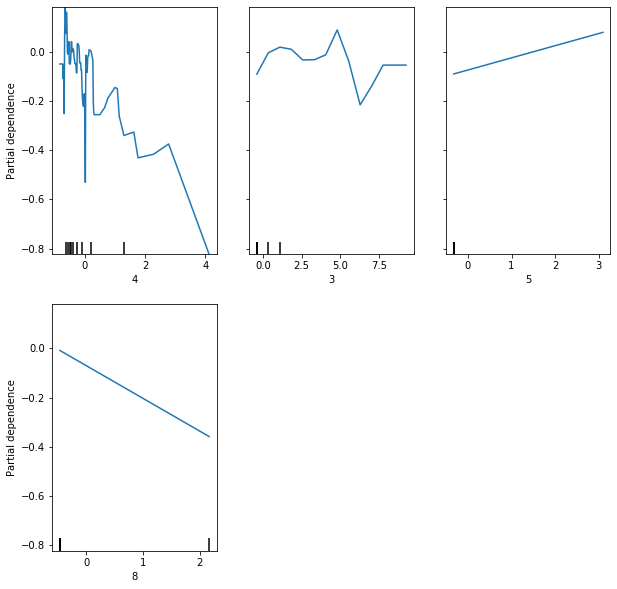

In [77]:
disp = plot_partial_dependence(gbc.best_estimator_, X_train, features = [4, 3, 5, 8])

plt.show()

In [73]:
X_train

array([[-0.57658047, -0.41898519,  1.9183814 , ..., -0.3423659 ,
         3.01960988, -0.50611254],
       [ 1.73436329,  2.38671921,  1.9183814 , ..., -0.3423659 ,
         3.01960988, -0.50611254],
       [-0.57658047, -0.41898519, -0.52127278, ..., -0.3423659 ,
        -0.33116861, -0.50611254],
       ...,
       [-0.57658047, -0.41898519, -0.52127278, ..., -0.3423659 ,
        -0.33116861, -0.50611254],
       [-0.57658047, -0.41898519,  1.9183814 , ..., -0.3423659 ,
        -0.33116861, -0.50611254],
       [ 1.73436329, -0.41898519, -0.52127278, ..., -0.3423659 ,
        -0.33116861,  1.97584515]])